# Inference and  Error Analysis NB

This notebook:
1. Runs rollout inference to generate predictions
2. Analyzes prediction errors comprehensively
3. Identifies problematic regions and timesteps
4. Creates animated visualizations
5. Provides actionable recommendations

---
## Config & Setup

In [48]:
import subprocess
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from pathlib import Path
import warnings
from datetime import datetime
import json
from IPython.display import Image, HTML, display
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline

In [49]:
# !pip install h5py seaborn matplotlib 

In [50]:
# Configuration - Edit these paths
import torch
import sys
import os
from pathlib import Path

# Add project root to path for imports
sys.path.insert(0, '/workspace/omv_v2.5')

TRUTH_H5_PATH = "/workspace/all_oak_data/h5s_v2.5_data/v2.5_0001.h5"
CHECKPOINT_PATH = "/workspace/omv_v2.5/checkpoints_v25_run32/step24000.pt"
STATS_PATH = "/workspace/omv_v2.5/data/raw_h5_stats_full.json"
RAW_H5_DIR = "/workspace/all_oak_data/h5s_v2.5_data"
PRED_H5_PATH = "/workspace/omv_v2.5/notebooks/predictions.h5"
REPORT_DIR = Path("/workspace/omv_v2.5/notebooks/reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Auto-detect last GPU for inference (reserved for inference)
num_gpus = torch.cuda.device_count()
DEVICE = f"cuda:{num_gpus - 1}" if num_gpus > 0 else "cpu"

# Model config (will be auto-detected from checkpoint)
MODEL_CONFIG = {
    "base_channels": 32,
    "depth": 4,
    "r": 2,
    "max_steps": 29,
}

print(f"Using device: {DEVICE}")
print(f"Checkpoint: {CHECKPOINT_PATH}")
print(f"Ground truth: {TRUTH_H5_PATH}")
print(f"Predictions: {PRED_H5_PATH}")
print(f"Reports: {REPORT_DIR}")


Using device: cuda:9
Checkpoint: /workspace/omv_v2.5/checkpoints_v25_run32/step24000.pt
Ground truth: /workspace/all_oak_data/h5s_v2.5_data/v2.5_0001.h5
Predictions: /workspace/omv_v2.5/notebooks/predictions.h5
Reports: /workspace/omv_v2.5/notebooks/reports


In [43]:
MODEL_CONFIG

{'base_channels': 32, 'depth': 4, 'r': 2, 'device': 'cuda:9', 'max_steps': 28}

---
## Step 1: Run Inference on h5 truth file

In [51]:
# Run evaluation using evaluate.py (saves predictions to H5)
import subprocess
import os

print("Running evaluate.py to generate predictions...")
print("="*80)

# Set up environment for subprocess to find voxel_ode module
env = os.environ.copy()
env['PYTHONPATH'] = '/workspace/omv_v2.5:' + env.get('PYTHONPATH', '')
env['CUDA_VISIBLE_DEVICES'] = DEVICE.split(':')[1] if ':' in DEVICE else '0'

cmd = [
    "python", "./scripts/evaluate.py",
    "--checkpoint", CHECKPOINT_PATH,
    "--stats_path", STATS_PATH,
    "--raw_h5_dir", RAW_H5_DIR,
    "--save_path", PRED_H5_PATH,
    "--device", "cuda:0",  # Will be remapped by CUDA_VISIBLE_DEVICES
    "--max_steps", "29",
]

print(f"Command: {' '.join(cmd)}")
print("="*80)

result = subprocess.run(cmd, env=env, capture_output=True, text=True, cwd='/workspace/omv_v2.5')
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr)
    raise RuntimeError(f"evaluate.py failed with return code {result.returncode}")

print("\nPredictions saved to:", PRED_H5_PATH)


Running evaluate.py to generate predictions...
Command: python ./scripts/evaluate.py --checkpoint /workspace/omv_v2.5/checkpoints_v25_run32/step24000.pt --stats_path /workspace/omv_v2.5/data/raw_h5_stats_full.json --raw_h5_dir /workspace/all_oak_data/h5s_v2.5_data --save_path /workspace/omv_v2.5/notebooks/predictions.h5 --device cuda:0 --max_steps 29
Using device: cuda:0
Loading stats from /workspace/omv_v2.5/data/raw_h5_stats_full.json...
Loading checkpoint from /workspace/omv_v2.5/checkpoints_v25_run32/step24000.pt...
Created VoxelAutoRegressor model with base_channels=32
Loaded model from step 24000
Model parameters: 308,712

Evaluating on 5 files:
  - v2.5_0001.h5
  - v2.5_0002.h5
  - v2.5_0003.h5
  - v2.5_0004.h5
  - v2.5_0005.h5

Starting 29-step rollout evaluation (NO teacher forcing)...
  Saved predictions to: /workspace/omv_v2.5/notebooks/predictions.h5

ROLLOUT EVALUATION RESULTS (step 24000)
  Wallclock time: 222.73s (44.55s per file)
  Files evaluated: 5

  [ROLLOUT 29-step

---
## Step 2: Load My Prediction h5 Data for analysis

In [52]:
# Load predictions and ground truth from the first test file
import h5py
import numpy as np

print("Loading predictions and ground truth...")

# The H5 file has groups for each test file: v2.5_0001.h5, v2.5_0002.h5, etc.
# We'll load the first one (matching TRUTH_H5_PATH) for detailed analysis
test_file_name = os.path.basename(TRUTH_H5_PATH)  # "v2.5_0001.h5"

with h5py.File(PRED_H5_PATH, 'r') as f:
    print(f"Available files in predictions: {list(f.keys())}")

    grp = f[test_file_name]
    pressure_pred = grp['pressure_ar'][:]
    temperature_pred = grp['temperature_ar'][:]
    wept_pred = grp['wept_ar'][:]

    pressure_true = grp['pressure_true'][:]
    temperature_true = grp['temperature_true'][:]
    wept_true = grp['wept_true'][:]

print(f"Data loaded successfully!")
print(f"   Pressure shape:    {pressure_pred.shape}")
print(f"   Temperature shape: {temperature_pred.shape}")
print(f"   WEPT shape:        {wept_pred.shape}")

# Compute valid timesteps (where we have data, not all -999)
T = pressure_true.shape[0]
valid_timesteps = []
for t in range(T):
    if (pressure_true[t] != -999).any():
        valid_timesteps.append(t)

print(f"   Valid timesteps: {len(valid_timesteps)} (from {valid_timesteps[0]} to {valid_timesteps[-1]})")


Loading predictions and ground truth...
Available files in predictions: ['v2.5_0001.h5', 'v2.5_0002.h5', 'v2.5_0003.h5', 'v2.5_0004.h5', 'v2.5_0005.h5']
Data loaded successfully!
   Pressure shape:    (30, 326, 70, 76)
   Temperature shape: (30, 326, 70, 76)
   WEPT shape:        (30, 326, 70, 76)
   Valid timesteps: 29 (from 0 to 28)


---
## 📊 Step 3: Compute Error Metrics

In [53]:
def compute_comprehensive_metrics(pred, true, field_name):
    """Compute comprehensive error metrics."""
    metrics = {}
    
    # Create mask for valid cells
    mask = (true != -999)
    
    if not mask.any():
        return None
    
    pred_valid = pred[mask]
    true_valid = true[mask]
    
    # Basic error
    error = pred_valid - true_valid
    abs_error = np.abs(error)
    
    # MSE and RMSE
    metrics['mse'] = np.mean(error ** 2)
    metrics['rmse'] = np.sqrt(metrics['mse'])
    
    # MAE
    metrics['mae'] = np.mean(abs_error)
    
    # Relative errors
    rel_error = abs_error / (np.abs(true_valid) + 1e-8)
    metrics['mape'] = 100.0 * np.mean(rel_error)  # Mean Absolute Percentage Error
    
    # Accuracy metrics (within X% tolerance)
    metrics['acc1'] = 100.0 * np.mean(rel_error <= 0.01)
    metrics['acc5'] = 100.0 * np.mean(rel_error <= 0.05)
    metrics['acc10'] = 100.0 * np.mean(rel_error <= 0.10)
    
    # Error distribution
    metrics['error_mean'] = np.mean(error)
    metrics['error_std'] = np.std(error)
    metrics['error_min'] = np.min(error)
    metrics['error_max'] = np.max(error)
    metrics['error_p25'] = np.percentile(error, 25)
    metrics['error_p50'] = np.percentile(error, 50)
    metrics['error_p75'] = np.percentile(error, 75)
    metrics['error_p95'] = np.percentile(error, 95)
    metrics['error_p99'] = np.percentile(error, 99)
    
    # R-squared
    ss_res = np.sum((true_valid - pred_valid) ** 2)
    ss_tot = np.sum((true_valid - np.mean(true_valid)) ** 2)
    metrics['r2'] = 1 - (ss_res / (ss_tot + 1e-8))
    
    # Bias (systematic error)
    metrics['bias'] = np.mean(pred_valid) - np.mean(true_valid)
    
    return metrics

# Compute metrics for each timestep and field
print("📊 Computing comprehensive error metrics...\n")

results = {
    'pressure': [],
    'temperature': [],
    'wept': []
}

for t in valid_timesteps[1:]:  # Skip t=0 (initialization)
    p_metrics = compute_comprehensive_metrics(pressure_pred[t], pressure_true[t], 'Pressure')
    t_metrics = compute_comprehensive_metrics(temperature_pred[t], temperature_true[t], 'Temperature')
    w_metrics = compute_comprehensive_metrics(wept_pred[t], wept_true[t], 'WEPT')
    
    results['pressure'].append(p_metrics)
    results['temperature'].append(t_metrics)
    results['wept'].append(w_metrics)

print("✅ Metrics computed for all timesteps!")

📊 Computing comprehensive error metrics...

✅ Metrics computed for all timesteps!


---
## 📈 Step 4: Summary Statistics & Performance Report

In [54]:
# Create performance summary table
print("\n" + "="*100)
print("🎯 MODEL PERFORMANCE SUMMARY")
print("="*100)

for field_name, field_results in results.items():
    print(f"\n📊 {field_name.upper()}")
    print("-"*100)
    
    if field_results[0] is None:
        print("  No valid data")
        continue
    
    # Average metrics across time
    avg_mse = np.mean([m['mse'] for m in field_results])
    avg_rmse = np.mean([m['rmse'] for m in field_results])
    avg_mae = np.mean([m['mae'] for m in field_results])
    avg_mape = np.mean([m['mape'] for m in field_results])
    avg_acc1 = np.mean([m['acc1'] for m in field_results])
    avg_acc5 = np.mean([m['acc5'] for m in field_results])
    avg_acc10 = np.mean([m['acc10'] for m in field_results])
    avg_r2 = np.mean([m['r2'] for m in field_results])
    avg_bias = np.mean([m['bias'] for m in field_results])
    
    print(f"  Mean Squared Error (MSE):        {avg_mse:12.6e}")
    print(f"  Root Mean Squared Error (RMSE):  {avg_rmse:12.6e}")
    print(f"  Mean Absolute Error (MAE):       {avg_mae:12.6e}")
    print(f"  Mean Abs. Percentage Error:      {avg_mape:12.2f}%")
    print(f"")
    print(f"  Accuracy (within 1%):            {avg_acc1:7.2f}%")
    print(f"  Accuracy (within 5%):            {avg_acc5:7.2f}%  ⭐")
    print(f"  Accuracy (within 10%):           {avg_acc10:7.2f}%")
    print(f"")
    print(f"  R² Score:                        {avg_r2:12.6f}")
    print(f"  Systematic Bias:                 {avg_bias:12.6e}")

print("\n" + "="*100)


🎯 MODEL PERFORMANCE SUMMARY

📊 PRESSURE
----------------------------------------------------------------------------------------------------
  Mean Squared Error (MSE):        5.339810e+00
  Root Mean Squared Error (RMSE):  2.051742e+00
  Mean Absolute Error (MAE):       1.532289e+00
  Mean Abs. Percentage Error:      808915053.07%

  Accuracy (within 1%):              51.47%
  Accuracy (within 5%):              75.22%  ⭐
  Accuracy (within 10%):             75.23%

  R² Score:                            0.999588
  Systematic Bias:                 -2.235552e-03

📊 TEMPERATURE
----------------------------------------------------------------------------------------------------
  Mean Squared Error (MSE):        2.931689e+01
  Root Mean Squared Error (RMSE):  5.144839e+00
  Mean Absolute Error (MAE):       2.175027e+00
  Mean Abs. Percentage Error:              3.40%

  Accuracy (within 1%):              74.58%
  Accuracy (within 5%):              84.39%  ⭐
  Accuracy (within 10%):      

In [ ]:
# Plot Predicted vs Truth for Pressure, Temperature, WEPT (3 cols x N test files rows)
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

# Test files (first 5)
test_files = [f"v2.5_{i:04d}.h5" for i in range(1, 6)]
RAW_H5_DIR = "/workspace/all_oak_data/h5s_v2.5_data"
PRED_H5_PATH = "/workspace/omv_v2.5/notebooks/predictions.h5"

# Pick a representative timestep and z-slice for visualization
t_viz = 15  # middle of rollout
z_viz = 38  # middle z-slice

fig, axes = plt.subplots(len(test_files), 3, figsize=(15, 4*len(test_files)))

with h5py.File(PRED_H5_PATH, 'r') as pred_f:
    for row, fname in enumerate(test_files):
        # Load ground truth
        truth_path = os.path.join(RAW_H5_DIR, fname)
        with h5py.File(truth_path, 'r') as truth_f:
            p_true = truth_f['Pressure'][t_viz, z_viz]
            t_true = truth_f['Temperature'][t_viz, z_viz]
            w_true = truth_f['WEPT'][t_viz, z_viz]
        
        # Load predictions
        grp = pred_f[fname]
        p_pred = grp['pressure_ar'][t_viz, z_viz]
        t_pred = grp['temperature_ar'][t_viz, z_viz]
        w_pred = grp['wept_ar'][t_viz, z_viz]
        
        # Mask sentinel values
        mask = (p_true != -999) & (t_true != -999)
        
        # Plot Pressure
        ax = axes[row, 0]
        p_true_masked = np.where(mask, p_true, np.nan)
        p_pred_masked = np.where(mask, p_pred, np.nan)
        vmin, vmax = np.nanmin(p_true_masked), np.nanmax(p_true_masked)
        im1 = ax.imshow(p_true_masked, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
        ax.contour(p_pred_masked, levels=10, colors='red', linewidths=0.5, alpha=0.7)
        ax.set_title(f'{fname} - Pressure (t={t_viz}, z={z_viz})\nBlue=Truth, Red contours=Pred')
        ax.set_ylabel('Y')
        if row == len(test_files) - 1:
            ax.set_xlabel('X')
        plt.colorbar(im1, ax=ax, label='bar')
        
        # Plot Temperature
        ax = axes[row, 1]
        t_true_masked = np.where(mask, t_true, np.nan)
        t_pred_masked = np.where(mask, t_pred, np.nan)
        vmin, vmax = np.nanmin(t_true_masked), np.nanmax(t_true_masked)
        im2 = ax.imshow(t_true_masked, aspect='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
        ax.contour(t_pred_masked, levels=10, colors='black', linewidths=0.5, alpha=0.7)
        ax.set_title(f'{fname} - Temperature (t={t_viz}, z={z_viz})\nColor=Truth, Black contours=Pred')
        if row == len(test_files) - 1:
            ax.set_xlabel('X')
        plt.colorbar(im2, ax=ax, label='C')
        
        # Plot WEPT
        ax = axes[row, 2]
        w_true_masked = np.where(mask, w_true, np.nan)
        w_pred_masked = np.where(mask, w_pred, np.nan)
        vmin, vmax = np.nanmin(w_true_masked), np.nanmax(w_true_masked)
        im3 = ax.imshow(w_true_masked, aspect='auto', cmap='plasma', vmin=vmin, vmax=vmax)
        ax.contour(w_pred_masked, levels=10, colors='white', linewidths=0.5, alpha=0.7)
        ax.set_title(f'{fname} - WEPT (t={t_viz}, z={z_viz})\nColor=Truth, White contours=Pred')
        if row == len(test_files) - 1:
            ax.set_xlabel('X')
        plt.colorbar(im3, ax=ax, label='J')

plt.suptitle(f'Predicted vs Truth Comparison (timestep={t_viz}, z-slice={z_viz})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORT_DIR / 'pred_vs_truth_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to: {REPORT_DIR / 'pred_vs_truth_comparison.png'}")


---
## 📉 Step 5: Temporal Error Evolution

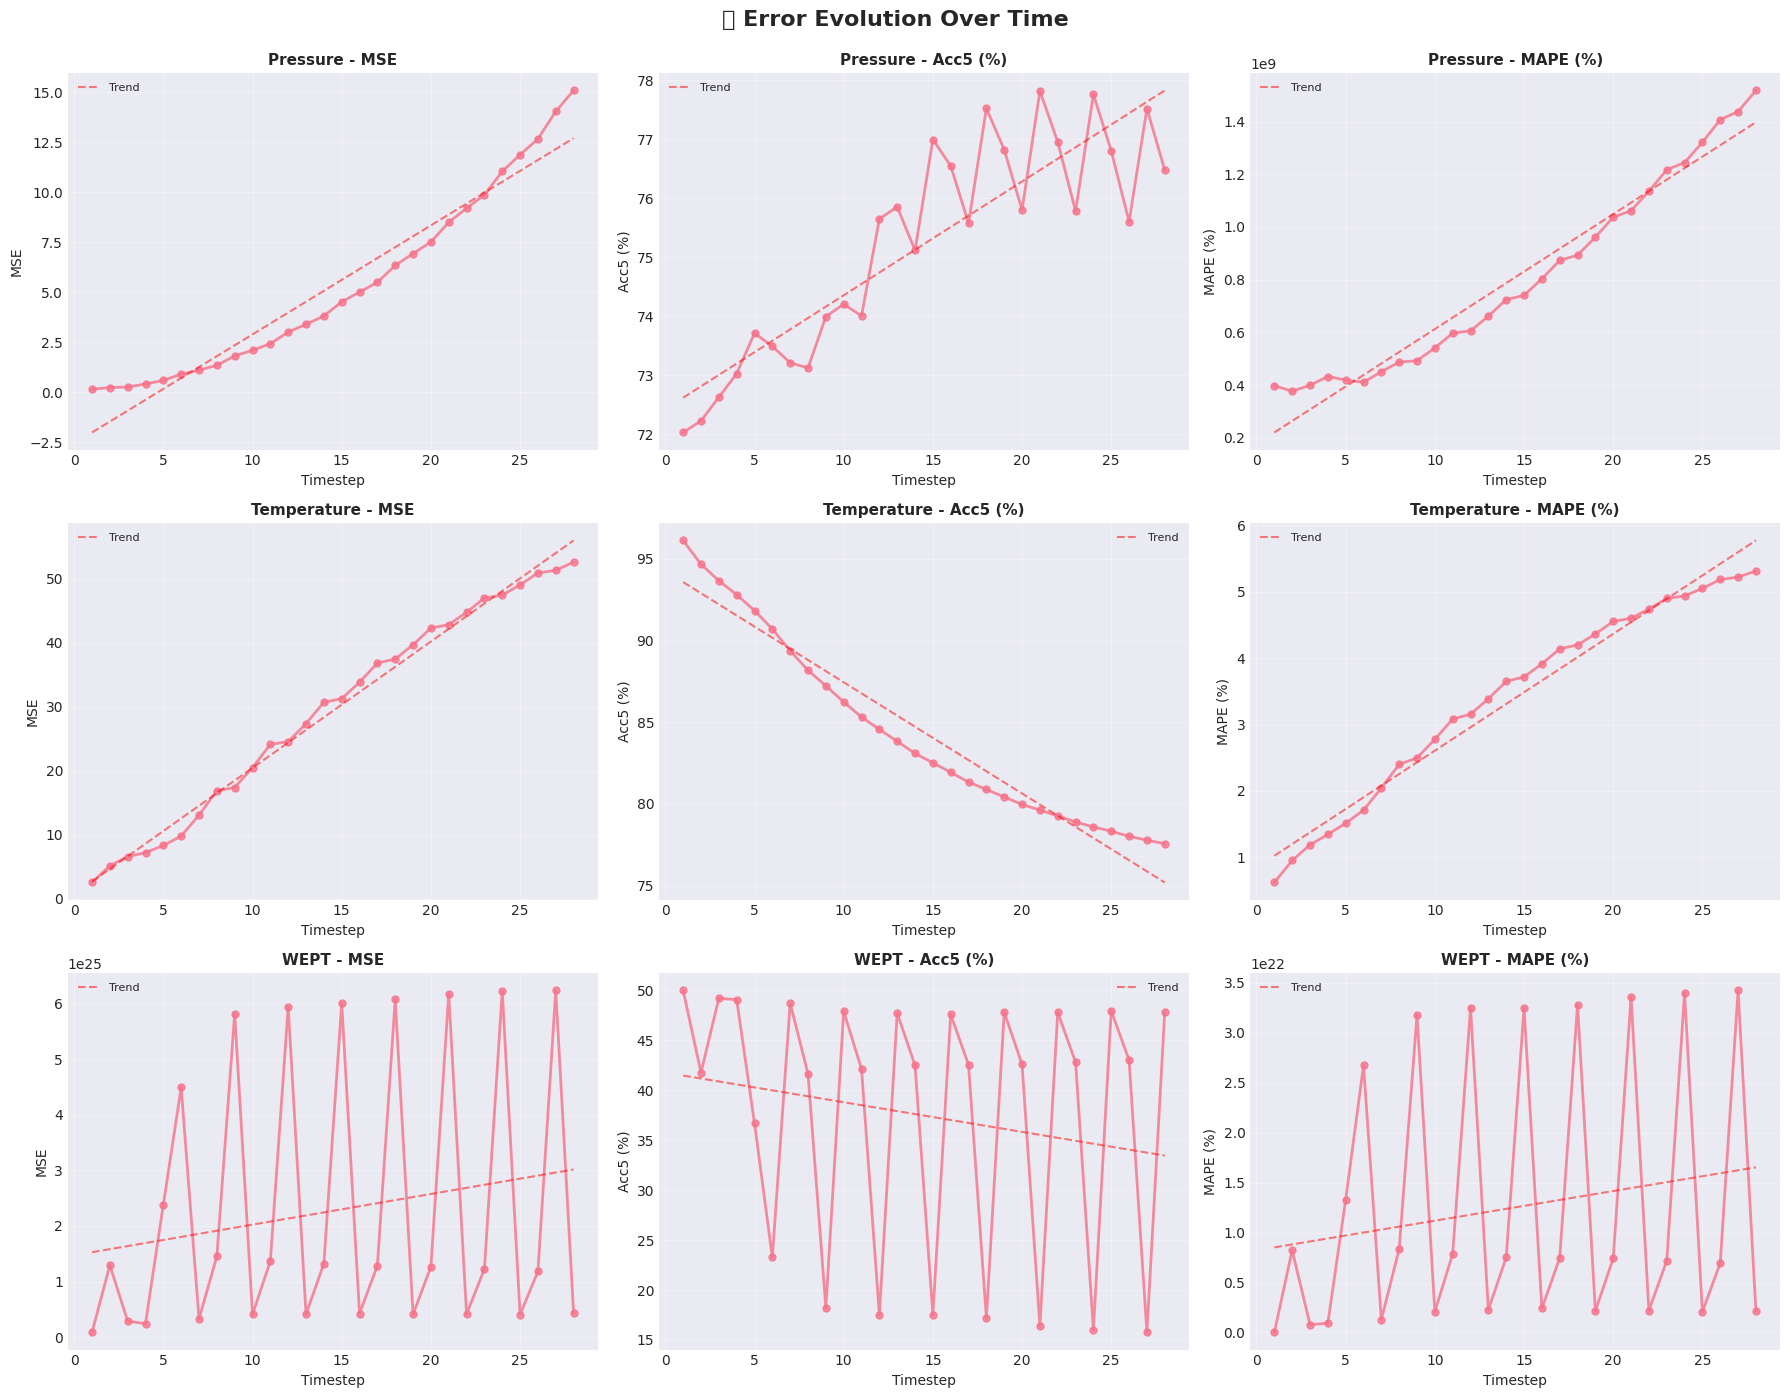

💾 Saved to: /workspace/omv_v2.5/notebooks/reports/temporal_error_evolution.png


In [55]:
# Plot error evolution over time
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
timesteps = valid_timesteps[1:]

fields = ['pressure', 'temperature', 'wept']
field_labels = ['Pressure', 'Temperature', 'WEPT']
metrics_to_plot = [('mse', 'MSE'), ('acc5', 'Acc5 (%)'), ('mape', 'MAPE (%)')]

for row, field in enumerate(fields):
    field_data = results[field]
    
    for col, (metric_key, metric_label) in enumerate(metrics_to_plot):
        ax = axes[row, col]
        values = [m[metric_key] for m in field_data]
        
        ax.plot(timesteps, values, 'o-', linewidth=2, markersize=5, alpha=0.8)
        ax.set_xlabel('Timestep', fontsize=10)
        ax.set_ylabel(metric_label, fontsize=10)
        ax.set_title(f'{field_labels[row]} - {metric_label}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(timesteps, values, 1)
        p = np.poly1d(z)
        ax.plot(timesteps, p(timesteps), "r--", alpha=0.5, linewidth=1.5, label='Trend')
        ax.legend(fontsize=8)

plt.suptitle('🎯 Error Evolution Over Time', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(REPORT_DIR / 'temporal_error_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {REPORT_DIR / 'temporal_error_evolution.png'}")

---
## 🔥 CRITICAL: Error Drift & Propagation Analysis (Autoregressive Rollout)

In [56]:
# Compute spatial error maps (averaged over time) - FIXED: Proper masking, no NaN
def compute_spatial_error_map(pred, true):
    """Compute absolute error map averaged over time - ONLY valid cells."""
    T, Z, Y, X = pred.shape
    error_sum = np.zeros((Z, Y, X), dtype=float)
    count = np.zeros((Z, Y, X), dtype=int)
    
    # Accumulate errors only for valid cells
    for t in range(1, T):  # Skip t=0
        mask = (true[t] != -999)
        error = np.abs(pred[t] - true[t])
        error_sum[mask] += error[mask]
        count[mask] += 1
    
    # Compute mean, avoiding division by zero
    error_mean = np.zeros_like(error_sum)
    valid_count = count > 0
    error_mean[valid_count] = error_sum[valid_count] / count[valid_count]
    
    return error_mean, count

print("🗺️ Computing spatial error maps...")

pressure_error_spatial, p_count = compute_spatial_error_map(pressure_pred, pressure_true)
temperature_error_spatial, t_count = compute_spatial_error_map(temperature_pred, temperature_true)
wept_error_spatial, w_count = compute_spatial_error_map(wept_pred, wept_true)

# Find slices with highest average error - FIXED: Only valid cells
def find_worst_slices(error_3d, count_3d, top_n=5):
    """Find Z slices with highest average error - ONLY valid cells."""
    Z = error_3d.shape[0]
    z_errors = []
    
    for z in range(Z):
        valid_mask = count_3d[z] > 0
        if valid_mask.any():
            z_errors.append(np.mean(error_3d[z][valid_mask]))
        else:
            z_errors.append(0.0)
    
    z_errors = np.array(z_errors)
    worst_indices = np.argsort(z_errors)[-top_n:][::-1]
    return worst_indices, z_errors[worst_indices]

p_worst_z, p_worst_errors = find_worst_slices(pressure_error_spatial, p_count)
t_worst_z, t_worst_errors = find_worst_slices(temperature_error_spatial, t_count)
w_worst_z, w_worst_errors = find_worst_slices(wept_error_spatial, w_count)

print(f"\n🎯 Worst Z-slices:")
print(f"  Pressure:    Z={p_worst_z[0]} (error={p_worst_errors[0]:.4e})")
print(f"  Temperature: Z={t_worst_z[0]} (error={t_worst_errors[0]:.4e})")
print(f"  WEPT:        Z={w_worst_z[0]} (error={w_worst_errors[0]:.4e})")

🗺️ Computing spatial error maps...

🎯 Worst Z-slices:
  Pressure:    Z=66 (error=3.2598e+00)
  Temperature: Z=155 (error=5.0677e+00)
  WEPT:        Z=89 (error=2.9791e+12)


🔥 ANALYZING ERROR DRIFT & ACCUMULATION OVER TIME
This shows how errors propagate in autoregressive rollout (critical for AR models!)



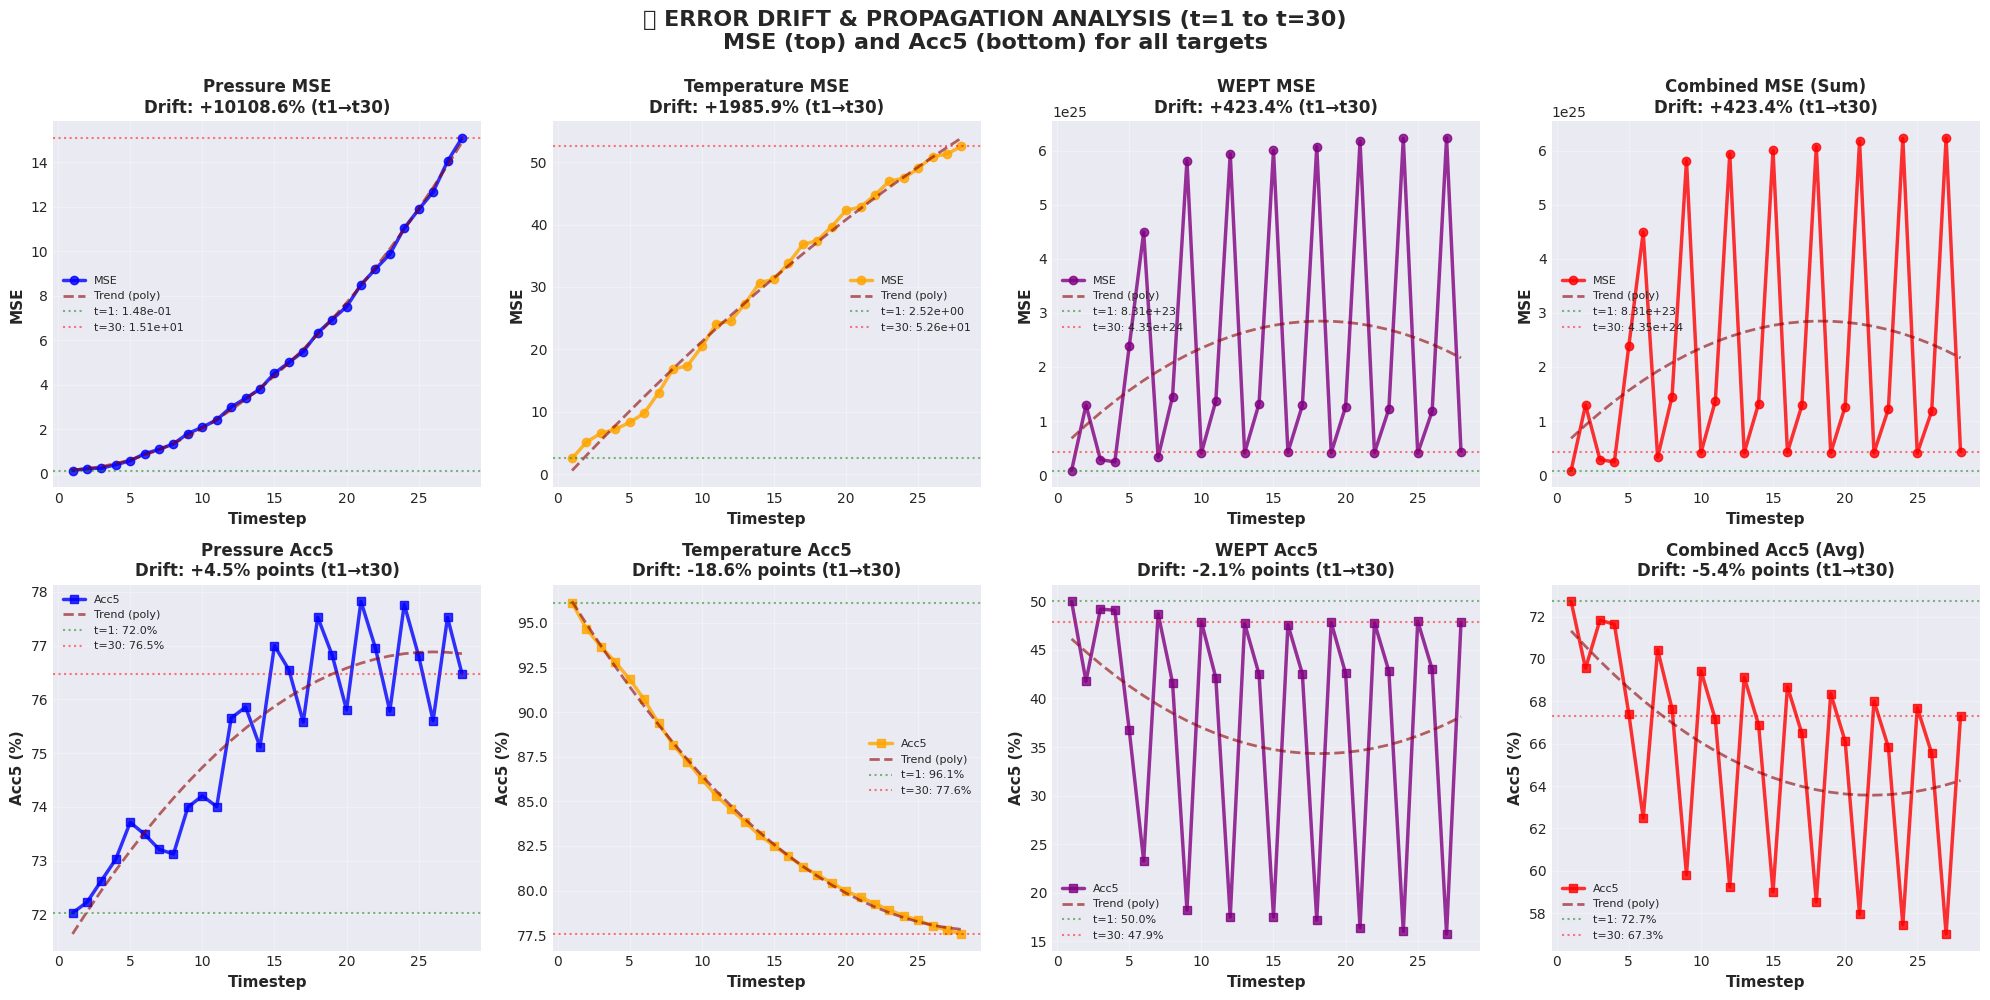

💾 Saved to: /workspace/omv_v2.5/notebooks/reports/error_drift_analysis.png

📊 DRIFT STATISTICS SUMMARY

🔴 MSE DRIFT (Higher MSE = Worse)
----------------------------------------------------------------------------------------------------
Pressure             | t=1:   1.4774e-01 | t=30:   1.5082e+01 | Drift: +10108.6% (+1.49e+01)
Temperature          | t=1:   2.5211e+00 | t=30:   5.2588e+01 | Drift:  +1985.9% (+5.01e+01)
WEPT                 | t=1:   8.3074e+23 | t=30:   4.3485e+24 | Drift:   +423.4% (+3.52e+24)
COMBINED (Sum)       | t=1:   8.3074e+23 | t=30:   4.3485e+24 | Drift:   +423.4% (+3.52e+24)

🟢 ACC5 DRIFT (Higher Acc5 = Better)
----------------------------------------------------------------------------------------------------
Pressure             | t=1:  72.03% | t=30:  76.48% | Drift:   +4.45% points
Temperature          | t=1:  96.13% | t=30:  77.57% | Drift:  -18.57% points
WEPT                 | t=1:  50.00% | t=30:  47.85% | Drift:   -2.15% points
COMBINED (Avg)       

In [57]:
# 🚨 ERROR DRIFT ANALYSIS - Most Important for AR Models!
# Track how MSE and Acc5 degrade as we rollout from t=1 to t=30

print("🔥 ANALYZING ERROR DRIFT & ACCUMULATION OVER TIME")
print("="*100)
print("This shows how errors propagate in autoregressive rollout (critical for AR models!)\n")

# Extract MSE and Acc5 for each field over time
timesteps = valid_timesteps[1:]  # Skip t=0

# Pressure
p_mse_over_time = [m['mse'] for m in results['pressure']]
p_acc5_over_time = [m['acc5'] for m in results['pressure']]

# Temperature
t_mse_over_time = [m['mse'] for m in results['temperature']]
t_acc5_over_time = [m['acc5'] for m in results['temperature']]

# WEPT
w_mse_over_time = [m['mse'] for m in results['wept']]
w_acc5_over_time = [m['acc5'] for m in results['wept']]

# Compute SUM (combined error across all fields)
# For MSE: sum of individual MSEs
sum_mse_over_time = [p + t + w for p, t, w in zip(p_mse_over_time, t_mse_over_time, w_mse_over_time)]

# For Acc5: average accuracy across all fields
sum_acc5_over_time = [(p + t + w) / 3 for p, t, w in zip(p_acc5_over_time, t_acc5_over_time, w_acc5_over_time)]

# Create 2x4 plot: Top row = MSE, Bottom row = Acc5
# Columns: Pressure, Temperature, WEPT, Combined
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Top row: MSE drift
mse_data = [
    (p_mse_over_time, 'Pressure MSE', 'blue'),
    (t_mse_over_time, 'Temperature MSE', 'orange'),
    (w_mse_over_time, 'WEPT MSE', 'purple'),
    (sum_mse_over_time, 'Combined MSE (Sum)', 'red')
]

for col, (mse_values, title, color) in enumerate(mse_data):
    ax = axes[0, col]
    ax.plot(timesteps, mse_values, 'o-', linewidth=2.5, markersize=6, 
            alpha=0.8, color=color, label='MSE')
    
    # Add polynomial trend line
    z = np.polyfit(timesteps, mse_values, 2)  # Quadratic fit
    p = np.poly1d(z)
    ax.plot(timesteps, p(timesteps), "--", alpha=0.6, linewidth=2, 
            color='darkred', label='Trend (poly)')
    
    # Highlight start and end values
    ax.axhline(mse_values[0], color='green', linestyle=':', alpha=0.5, 
              linewidth=1.5, label=f't=1: {mse_values[0]:.2e}')
    ax.axhline(mse_values[-1], color='red', linestyle=':', alpha=0.5, 
              linewidth=1.5, label=f't=30: {mse_values[-1]:.2e}')
    
    # Calculate drift rate
    drift_rate = (mse_values[-1] - mse_values[0]) / mse_values[0] * 100
    
    ax.set_xlabel('Timestep', fontsize=11, fontweight='bold')
    ax.set_ylabel('MSE', fontsize=11, fontweight='bold')
    ax.set_title(f'{title}\nDrift: {drift_rate:+.1f}% (t1→t30)', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

# Bottom row: Acc5 drift
acc5_data = [
    (p_acc5_over_time, 'Pressure Acc5', 'blue'),
    (t_acc5_over_time, 'Temperature Acc5', 'orange'),
    (w_acc5_over_time, 'WEPT Acc5', 'purple'),
    (sum_acc5_over_time, 'Combined Acc5 (Avg)', 'red')
]

for col, (acc5_values, title, color) in enumerate(acc5_data):
    ax = axes[1, col]
    ax.plot(timesteps, acc5_values, 's-', linewidth=2.5, markersize=6, 
            alpha=0.8, color=color, label='Acc5')
    
    # Add polynomial trend line
    z = np.polyfit(timesteps, acc5_values, 2)
    p = np.poly1d(z)
    ax.plot(timesteps, p(timesteps), "--", alpha=0.6, linewidth=2, 
            color='darkred', label='Trend (poly)')
    
    # Highlight start and end values
    ax.axhline(acc5_values[0], color='green', linestyle=':', alpha=0.5, 
              linewidth=1.5, label=f't=1: {acc5_values[0]:.1f}%')
    ax.axhline(acc5_values[-1], color='red', linestyle=':', alpha=0.5, 
              linewidth=1.5, label=f't=30: {acc5_values[-1]:.1f}%')
    
    # Calculate drift
    drift_abs = acc5_values[-1] - acc5_values[0]
    
    ax.set_xlabel('Timestep', fontsize=11, fontweight='bold')
    ax.set_ylabel('Acc5 (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{title}\nDrift: {drift_abs:+.1f}% points (t1→t30)', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

plt.suptitle('🔥 ERROR DRIFT & PROPAGATION ANALYSIS (t=1 to t=30)\nMSE (top) and Acc5 (bottom) for all targets', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(REPORT_DIR / 'error_drift_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {REPORT_DIR / 'error_drift_analysis.png'}")

# Print detailed drift statistics
print("\n" + "="*100)
print("📊 DRIFT STATISTICS SUMMARY")
print("="*100)

print("\n🔴 MSE DRIFT (Higher MSE = Worse)")
print("-"*100)
for name, mse_vals in [('Pressure', p_mse_over_time), 
                        ('Temperature', t_mse_over_time), 
                        ('WEPT', w_mse_over_time),
                        ('COMBINED (Sum)', sum_mse_over_time)]:
    mse_t1 = mse_vals[0]
    mse_t30 = mse_vals[-1]
    mse_drift_pct = (mse_t30 - mse_t1) / mse_t1 * 100
    mse_drift_abs = mse_t30 - mse_t1
    
    print(f"{name:20} | t=1: {mse_t1:12.4e} | t=30: {mse_t30:12.4e} | "
          f"Drift: {mse_drift_pct:+8.1f}% ({mse_drift_abs:+.2e})")

print("\n🟢 ACC5 DRIFT (Higher Acc5 = Better)")
print("-"*100)
for name, acc5_vals in [('Pressure', p_acc5_over_time), 
                         ('Temperature', t_acc5_over_time), 
                         ('WEPT', w_acc5_over_time),
                         ('COMBINED (Avg)', sum_acc5_over_time)]:
    acc5_t1 = acc5_vals[0]
    acc5_t30 = acc5_vals[-1]
    acc5_drift = acc5_t30 - acc5_t1
    
    print(f"{name:20} | t=1: {acc5_t1:6.2f}% | t=30: {acc5_t30:6.2f}% | "
          f"Drift: {acc5_drift:+7.2f}% points")

print("\n" + "="*100)
print("⚠️  KEY INSIGHTS:")
print("  • Positive MSE drift = Error INCREASING over time (BAD for AR rollout)")
print("  • Negative Acc5 drift = Accuracy DECREASING over time (BAD for AR rollout)")
print("  • Large drift indicates error accumulation - needs stabilization techniques!")
print("="*100)

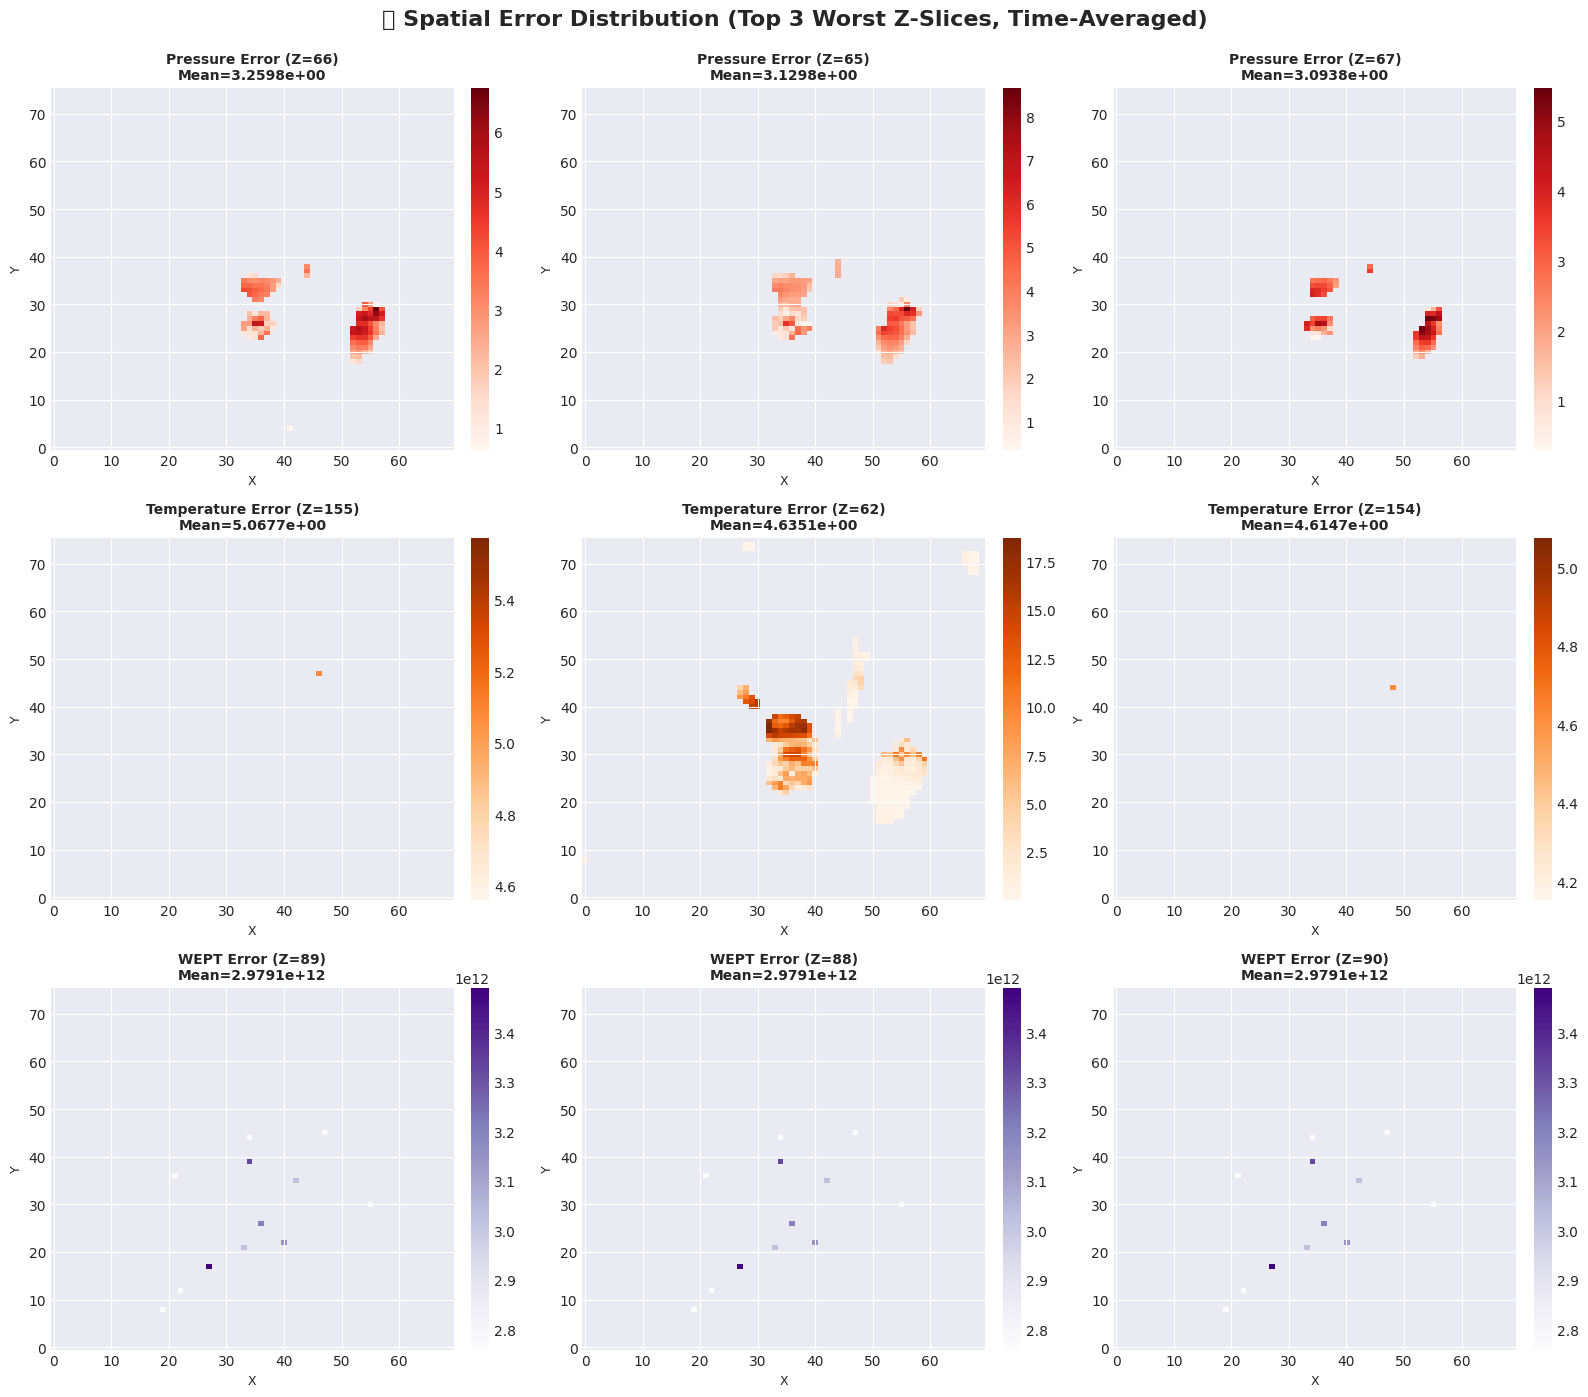

💾 Saved to: /workspace/omv_v2.5/notebooks/reports/spatial_error_heatmaps.png


In [58]:
# Visualize worst slices - FIXED: Use masked arrays properly
fig, axes = plt.subplots(3, 3, figsize=(16, 14))

error_maps = [
    (pressure_error_spatial, p_count, p_worst_z, 'Pressure', 'Reds'),
    (temperature_error_spatial, t_count, t_worst_z, 'Temperature', 'Oranges'),
    (wept_error_spatial, w_count, w_worst_z, 'WEPT', 'Purples')
]

for row, (error_map, count_map, worst_slices, field_name, cmap) in enumerate(error_maps):
    for col, z_idx in enumerate(worst_slices[:3]):
        ax = axes[row, col]
        
        # Mask invalid regions properly
        error_slice = error_map[z_idx, :, :]
        mask_slice = count_map[z_idx, :, :] > 0
        error_masked = np.ma.masked_where(~mask_slice, error_slice)
        
        im = ax.imshow(error_masked.T, 
                      cmap=cmap, origin='lower', aspect='auto',
                      interpolation='nearest')
        
        # Only compute mean on valid cells
        if mask_slice.any():
            mean_val = np.mean(error_slice[mask_slice])
        else:
            mean_val = 0.0
        
        ax.set_title(f'{field_name} Error (Z={z_idx})\nMean={mean_val:.4e}',
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('X', fontsize=9)
        ax.set_ylabel('Y', fontsize=9)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('🗺️ Spatial Error Distribution (Top 3 Worst Z-Slices, Time-Averaged)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(REPORT_DIR / 'spatial_error_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {REPORT_DIR / 'spatial_error_heatmaps.png'}")

---
## 📊 Step 7: Error Distribution Analysis

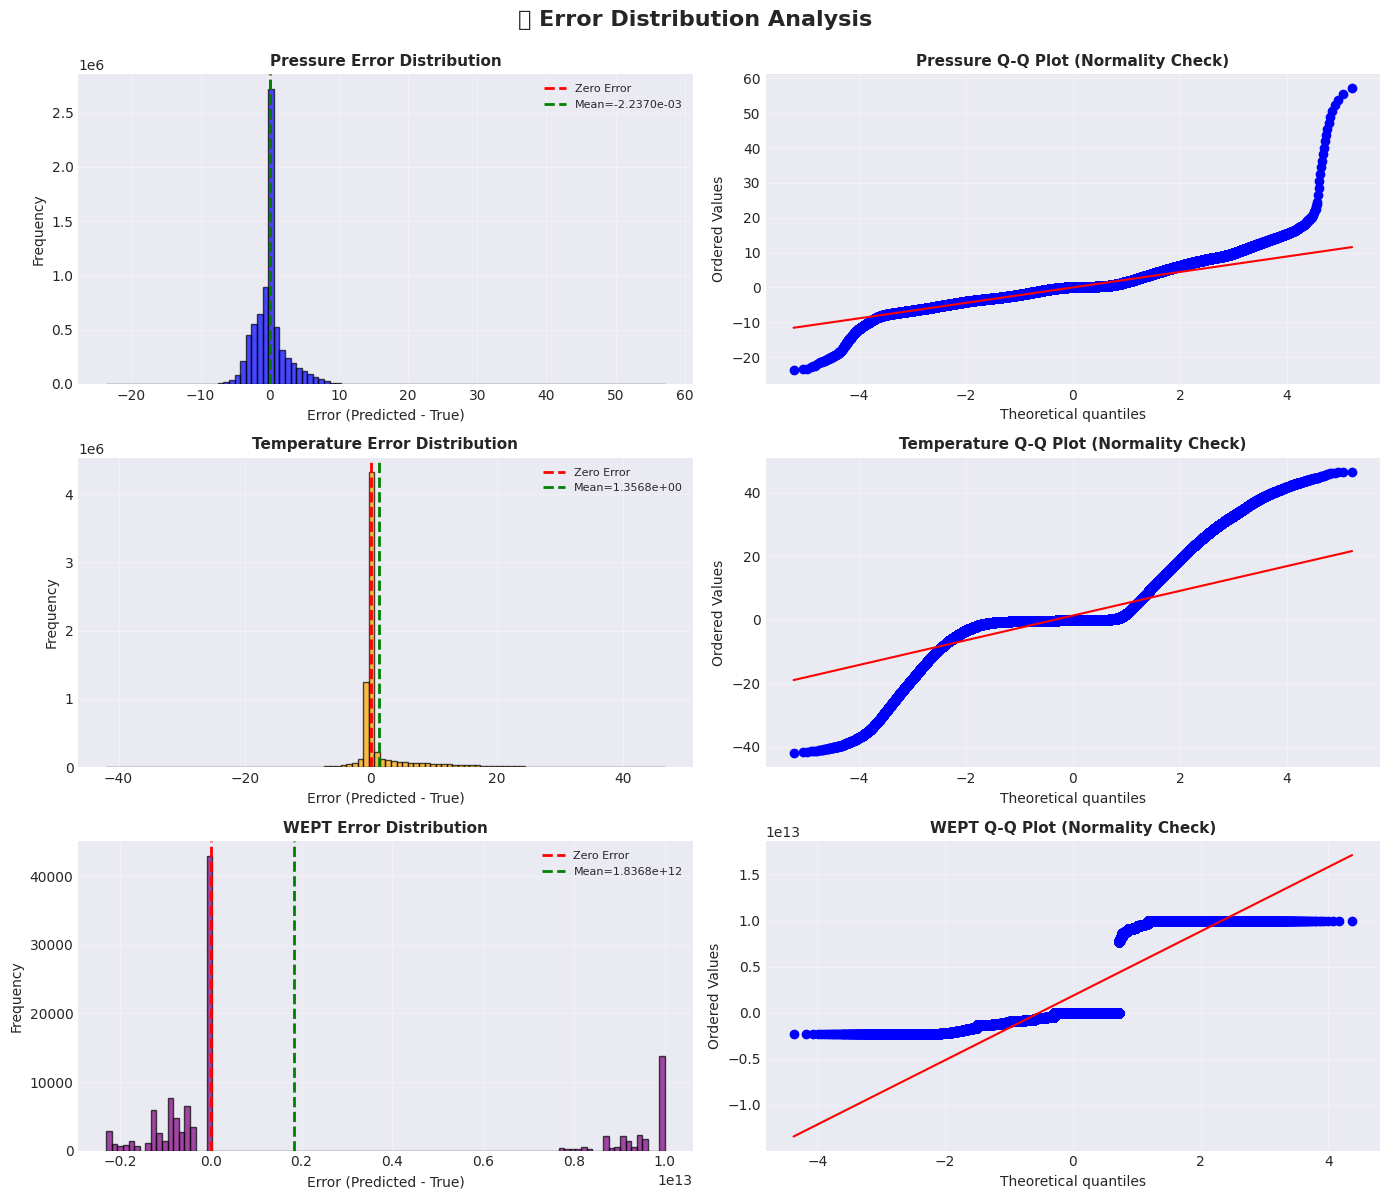

💾 Saved to: /workspace/omv_v2.5/notebooks/reports/error_distributions.png


In [59]:
# Collect all errors for distribution analysis
def collect_all_errors(pred, true):
    """Collect all valid errors across space and time."""
    mask = (true != -999)
    errors = pred[mask] - true[mask]
    return errors

p_all_errors = collect_all_errors(pressure_pred[1:], pressure_true[1:])
t_all_errors = collect_all_errors(temperature_pred[1:], temperature_true[1:])
w_all_errors = collect_all_errors(wept_pred[1:], wept_true[1:])

# Plot distributions
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

error_data = [
    (p_all_errors, 'Pressure', 'blue'),
    (t_all_errors, 'Temperature', 'orange'),
    (w_all_errors, 'WEPT', 'purple')
]

for row, (errors, field_name, color) in enumerate(error_data):
    # Histogram
    ax1 = axes[row, 0]
    ax1.hist(errors, bins=100, edgecolor='black', alpha=0.7, color=color)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax1.axvline(np.mean(errors), color='green', linestyle='--', linewidth=2, label=f'Mean={np.mean(errors):.4e}')
    ax1.set_xlabel('Error (Predicted - True)', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.set_title(f'{field_name} Error Distribution', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Q-Q plot (check normality)
    ax2 = axes[row, 1]
    from scipy import stats
    stats.probplot(errors, dist="norm", plot=ax2)
    ax2.set_title(f'{field_name} Q-Q Plot (Normality Check)', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)

plt.suptitle('📊 Error Distribution Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(REPORT_DIR / 'error_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {REPORT_DIR / 'error_distributions.png'}")

In [60]:
def create_error_animation(pred, true, field_name, z_slice, save_path):
    """Create animated GIF showing error evolution over time - PROPER masking."""
    print(f"🎬 Creating {field_name} animation...")
    
    # Compute errors maintaining -999 sentinels (no NaN conversion)
    errors = np.abs(pred - true)
    errors[true == -999] = -999  # Keep sentinels
    
    # Find valid error range for colorbar (from valid cells only)
    valid_errors = []
    for t in valid_timesteps[1:]:
        mask = (errors[t, z_slice, :, :] != -999)
        if mask.any():
            valid_errors.extend(errors[t, z_slice, :, :][mask].tolist())
    
    vmin_error = 0
    vmax_error = np.percentile(valid_errors, 99) if len(valid_errors) > 0 else 1
    
    # Find valid ranges for pred and true
    valid_pred = []
    valid_true = []
    for t in valid_timesteps[1:]:
        mask = (true[t, z_slice, :, :] != -999)
        if mask.any():
            valid_pred.extend(pred[t, z_slice, :, :][mask].tolist())
            valid_true.extend(true[t, z_slice, :, :][mask].tolist())
    
    vmin_pred = np.percentile(valid_pred, 1) if len(valid_pred) > 0 else 0
    vmax_pred = np.percentile(valid_pred, 99) if len(valid_pred) > 0 else 1
    vmin_true = np.percentile(valid_true, 1) if len(valid_true) > 0 else 0
    vmax_true = np.percentile(valid_true, 99) if len(valid_true) > 0 else 1
    
    # Create figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Initialize with first frame
    t0 = valid_timesteps[0]
    
    # Error heatmap - properly masked
    error_masked = np.ma.masked_where(errors[t0, z_slice, :, :] == -999, 
                                     errors[t0, z_slice, :, :])
    im1 = axes[0].imshow(error_masked.T, 
                        cmap='Reds', origin='lower', aspect='auto',
                        vmin=vmin_error, vmax=vmax_error)
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046)
    
    # Prediction - properly masked
    pred_masked = np.ma.masked_where(true[t0, z_slice, :, :] == -999, 
                                     pred[t0, z_slice, :, :])
    im2 = axes[1].imshow(pred_masked.T, cmap='viridis', origin='lower', aspect='auto',
                        vmin=vmin_pred, vmax=vmax_pred)
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046)
    
    # Ground Truth - properly masked
    true_masked = np.ma.masked_where(true[t0, z_slice, :, :] == -999, 
                                     true[t0, z_slice, :, :])
    im3 = axes[2].imshow(true_masked.T, cmap='viridis', origin='lower', aspect='auto',
                        vmin=vmin_true, vmax=vmax_true)
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    cbar3 = plt.colorbar(im3, ax=axes[2], fraction=0.046)
    
    def update(frame):
        t = valid_timesteps[frame]
        
        # Update error image
        error_masked = np.ma.masked_where(errors[t, z_slice, :, :] == -999, 
                                         errors[t, z_slice, :, :])
        im1.set_data(error_masked.T)
        axes[0].set_title(f'Absolute Error (t={t})', fontsize=12, fontweight='bold')
        
        # Update prediction image
        pred_masked = np.ma.masked_where(true[t, z_slice, :, :] == -999, 
                                         pred[t, z_slice, :, :])
        im2.set_data(pred_masked.T)
        axes[1].set_title(f'Predicted (t={t})', fontsize=12, fontweight='bold')
        
        # Update ground truth image
        true_masked = np.ma.masked_where(true[t, z_slice, :, :] == -999, 
                                         true[t, z_slice, :, :])
        im3.set_data(true_masked.T)
        axes[2].set_title(f'Ground Truth (t={t})', fontsize=12, fontweight='bold')
        
        fig.suptitle(f'{field_name} Error Evolution (Z={z_slice})', 
                    fontsize=14, fontweight='bold')
        
        return [im1, im2, im3]
    
    anim = FuncAnimation(fig, update, frames=len(valid_timesteps), interval=300, repeat=True, blit=False)
    writer = PillowWriter(fps=3)
    anim.save(save_path, writer=writer)
    plt.close()
    
    print(f"   ✅ Saved to: {save_path}")
    return save_path

In [61]:
# Create animations for worst slices
print("🎬 Creating animated error visualizations...\n")

p_gif_path = create_error_animation(pressure_pred, pressure_true, 
                                    'Pressure', p_worst_z[0],
                                    REPORT_DIR / 'pressure_error_animation.gif')

t_gif_path = create_error_animation(temperature_pred, temperature_true,
                                    'Temperature', t_worst_z[0],
                                    REPORT_DIR / 'temperature_error_animation.gif')

w_gif_path = create_error_animation(wept_pred, wept_true,
                                    'WEPT', w_worst_z[0],
                                    REPORT_DIR / 'wept_error_animation.gif')

print("\n✅ All animations created!")

🎬 Creating animated error visualizations...

🎬 Creating Pressure animation...
   ✅ Saved to: /workspace/omv_v2.5/notebooks/reports/pressure_error_animation.gif
🎬 Creating Temperature animation...
   ✅ Saved to: /workspace/omv_v2.5/notebooks/reports/temperature_error_animation.gif
🎬 Creating WEPT animation...
   ✅ Saved to: /workspace/omv_v2.5/notebooks/reports/wept_error_animation.gif

✅ All animations created!


🎬 Pressure Error Animation:


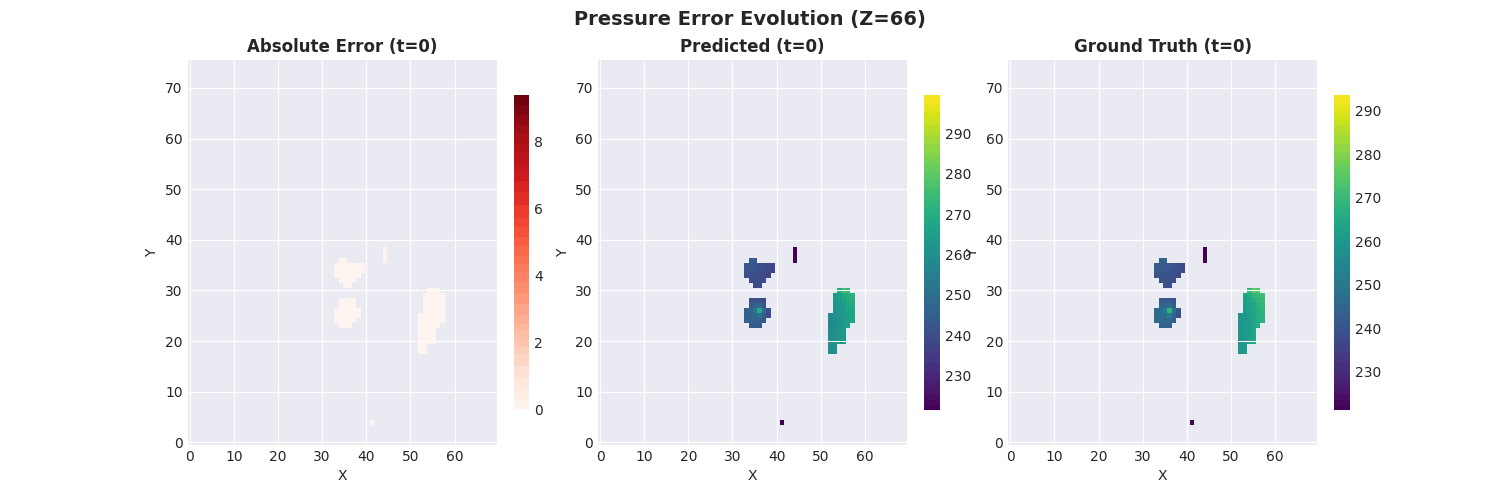


🎬 Temperature Error Animation:


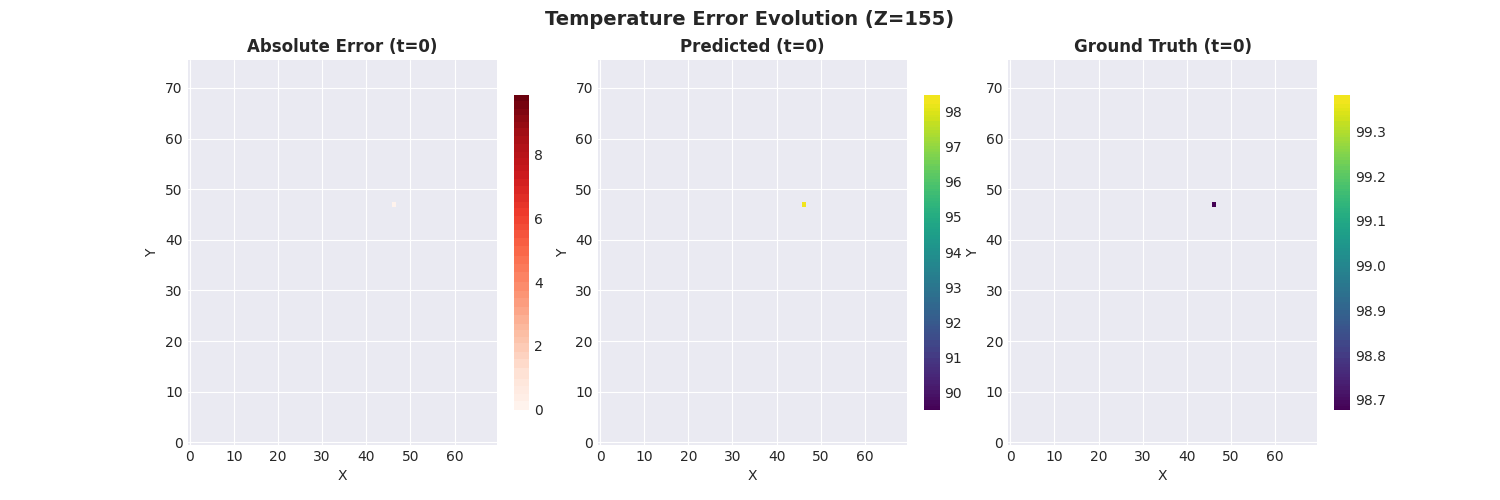


🎬 WEPT Error Animation:


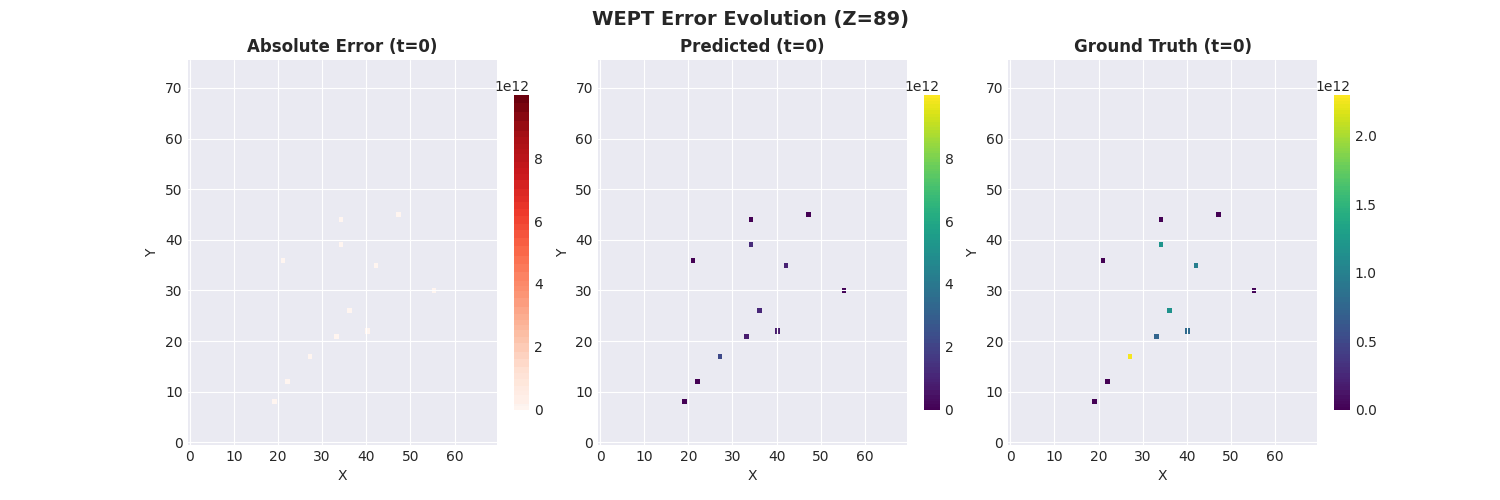

In [62]:
# Display animations inline
print("🎬 Pressure Error Animation:")
display(Image(filename=p_gif_path))

print("\n🎬 Temperature Error Animation:")
display(Image(filename=t_gif_path))

print("\n🎬 WEPT Error Animation:")
display(Image(filename=w_gif_path))

---
## 🔍 Step 9: Per-Slice Error Analysis

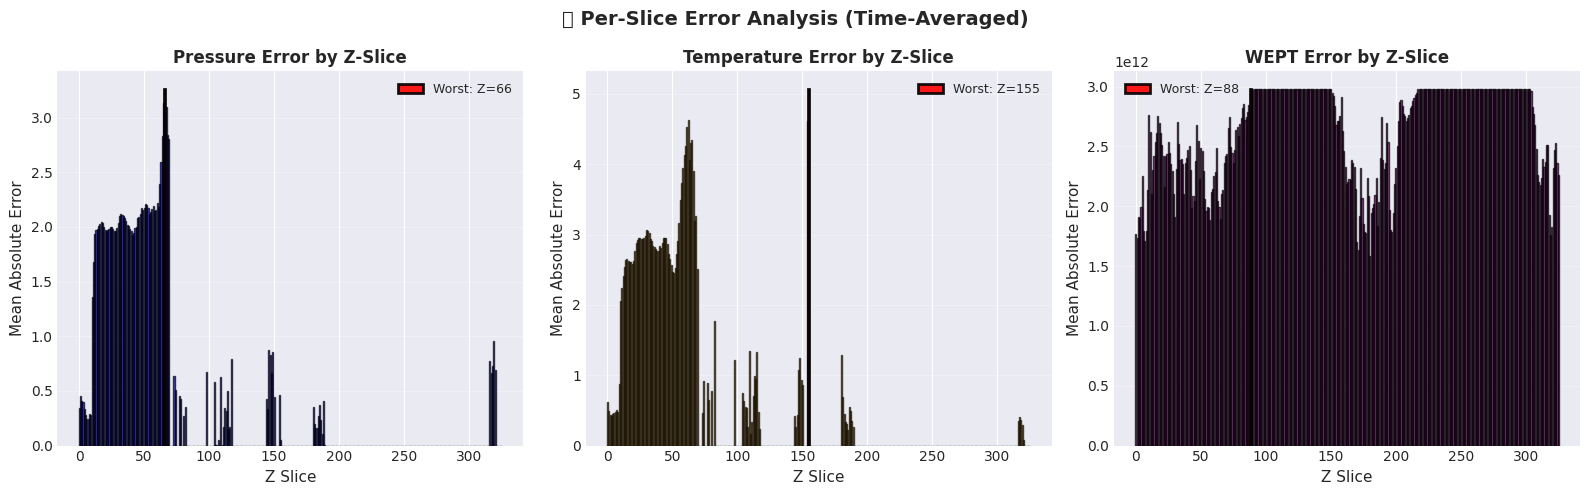

💾 Saved to: /workspace/omv_v2.5/notebooks/reports/per_slice_errors.png


In [63]:
# Compute error for each Z-slice - FIXED: Proper masking
def compute_per_slice_errors(pred, true):
    """Compute average error for each Z slice - ONLY valid cells."""
    T, Z, Y, X = pred.shape
    slice_errors = []
    
    for z in range(Z):
        errors_z = []
        for t in range(1, T):  # Skip t=0
            mask = (true[t, z, :, :] != -999)
            if mask.any():
                error = np.abs(pred[t, z, :, :] - true[t, z, :, :])
                errors_z.extend(error[mask].tolist())
        
        if len(errors_z) > 0:
            slice_errors.append(np.mean(errors_z))
        else:
            slice_errors.append(0.0)
    
    return np.array(slice_errors)

p_slice_errors = compute_per_slice_errors(pressure_pred, pressure_true)
t_slice_errors = compute_per_slice_errors(temperature_pred, temperature_true)
w_slice_errors = compute_per_slice_errors(wept_pred, wept_true)

# Plot per-slice errors
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

slice_data = [
    (p_slice_errors, 'Pressure', 'blue'),
    (t_slice_errors, 'Temperature', 'orange'),
    (w_slice_errors, 'WEPT', 'purple')
]

for ax, (errors, field_name, color) in zip(axes, slice_data):
    z_indices = np.arange(len(errors))
    
    # Only plot/highlight slices with valid data
    valid_slices = errors > 0
    
    ax.bar(z_indices, errors, color=color, alpha=0.7, edgecolor='black')
    
    # Highlight worst slice (from valid slices only)
    if valid_slices.any():
        worst_idx = np.argmax(errors)
        ax.bar(worst_idx, errors[worst_idx], color='red', alpha=0.9, 
              edgecolor='black', linewidth=2, label=f'Worst: Z={worst_idx}')
    
    ax.set_xlabel('Z Slice', fontsize=11)
    ax.set_ylabel('Mean Absolute Error', fontsize=11)
    ax.set_title(f'{field_name} Error by Z-Slice', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=9)

plt.suptitle('🔍 Per-Slice Error Analysis (Time-Averaged)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORT_DIR / 'per_slice_errors.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {REPORT_DIR / 'per_slice_errors.png'}")

---
## 🎯 Step 10: Error Correlation Analysis

🎯 Analyzing error correlations...



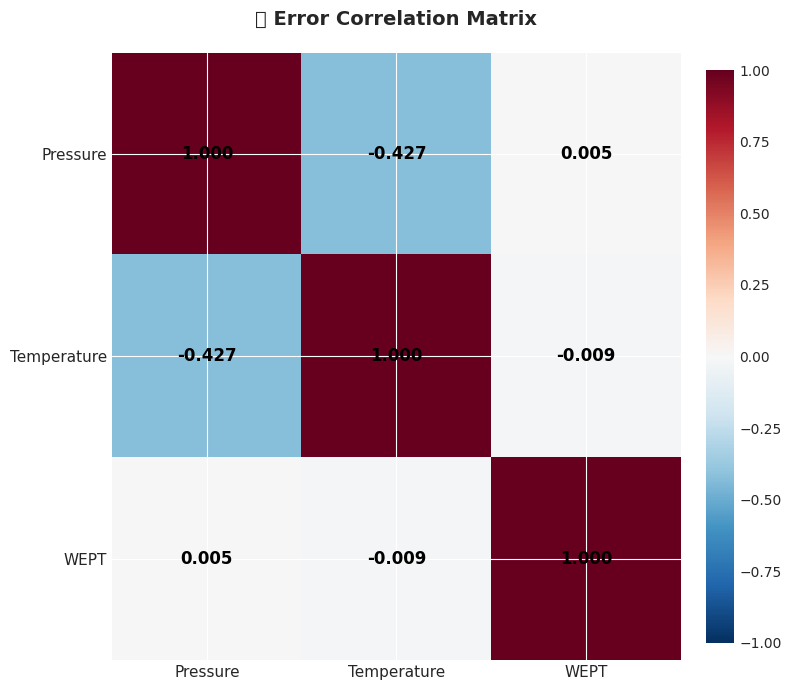

💾 Saved to: /workspace/omv_v2.5/notebooks/reports/error_correlation.png

📊 Correlation Insights:
  Pressure-Temperature: -0.427
  Pressure-WEPT:        0.005
  Temperature-WEPT:     -0.009


In [64]:
# Analyze correlation between errors in different fields
print("🎯 Analyzing error correlations...\n")

# Flatten errors for correlation
p_errors_flat = p_all_errors.flatten()
t_errors_flat = t_all_errors.flatten()
w_errors_flat = w_all_errors.flatten()

# Ensure same length (in case of different masks)
min_len = min(len(p_errors_flat), len(t_errors_flat), len(w_errors_flat))
p_errors_flat = p_errors_flat[:min_len]
t_errors_flat = t_errors_flat[:min_len]
w_errors_flat = w_errors_flat[:min_len]

# Compute correlation matrix
error_matrix = np.vstack([p_errors_flat, t_errors_flat, w_errors_flat])
corr_matrix = np.corrcoef(error_matrix)

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(8, 7))

im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

labels = ['Pressure', 'Temperature', 'WEPT']
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=11)
ax.set_yticklabels(labels, fontsize=11)

# Add correlation values
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, f'{corr_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black",
                      fontsize=12, fontweight='bold')

ax.set_title('🎯 Error Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(REPORT_DIR / 'error_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {REPORT_DIR / 'error_correlation.png'}")
print(f"\n📊 Correlation Insights:")
print(f"  Pressure-Temperature: {corr_matrix[0, 1]:.3f}")
print(f"  Pressure-WEPT:        {corr_matrix[0, 2]:.3f}")
print(f"  Temperature-WEPT:     {corr_matrix[1, 2]:.3f}")

---
## 💡 Step 11: Recommendations & Diagnostics

In [65]:
def generate_recommendations(results, slice_errors, field_name):
    """Generate actionable recommendations based on error analysis."""
    recommendations = []
    
    # Check average accuracy
    avg_acc5 = np.mean([m['acc5'] for m in results])
    avg_mape = np.mean([m['mape'] for m in results])
    avg_bias = np.mean([m['bias'] for m in results])
    
    # Recommendation 1: Overall performance
    if avg_acc5 < 50:
        recommendations.append({
            'priority': 'HIGH',
            'issue': f'Low accuracy ({avg_acc5:.1f}% within 5% tolerance)',
            'recommendation': 'Consider increasing model capacity (more channels/depth) or training longer',
            'action': 'Try base_channels=96 or depth=12'
        })
    elif avg_acc5 < 70:
        recommendations.append({
            'priority': 'MEDIUM',
            'issue': f'Moderate accuracy ({avg_acc5:.1f}%)',
            'recommendation': 'Fine-tune hyperparameters or add more training data',
            'action': 'Consider data augmentation or curriculum learning'
        })
    
    # Recommendation 2: Systematic bias
    if abs(avg_bias) > 0.01 * np.mean([np.mean(pressure_true[t][pressure_true[t] != -999]) for t in valid_timesteps[1:]]):
        bias_direction = 'over-predicting' if avg_bias > 0 else 'under-predicting'
        recommendations.append({
            'priority': 'MEDIUM',
            'issue': f'Systematic bias detected ({bias_direction})',
            'recommendation': 'Check data normalization and consider bias correction layer',
            'action': 'Review stats computation and add learnable bias term'
        })
    
    # Recommendation 3: Error growth over time
    early_errors = [m['mse'] for m in results[:5]]
    late_errors = [m['mse'] for m in results[-5:]]
    if np.mean(late_errors) > 2 * np.mean(early_errors):
        recommendations.append({
            'priority': 'HIGH',
            'issue': 'Error accumulation over time',
            'recommendation': 'Implement teacher forcing schedule or add state correction',
            'action': 'Use scheduled sampling or add auxiliary loss on intermediate states'
        })
    
    # Recommendation 4: Spatial heterogeneity
    worst_slice = np.argmax(slice_errors)
    best_slice = np.argmin(slice_errors)
    if slice_errors[worst_slice] > 3 * slice_errors[best_slice]:
        recommendations.append({
            'priority': 'MEDIUM',
            'issue': f'High spatial heterogeneity (worst Z={worst_slice})',
            'recommendation': 'Add attention mechanism or increase receptive field',
            'action': 'Consider adding self-attention layers or increasing depth'
        })
    
    # Recommendation 5: High MAPE
    if avg_mape > 20:
        recommendations.append({
            'priority': 'HIGH',
            'issue': f'High relative error ({avg_mape:.1f}%)',
            'recommendation': 'Focus on regions with extreme values',
            'action': 'Add weighted loss for high-value regions or use log-scale normalization'
        })
    
    return recommendations

# Generate recommendations for each field
print("\n" + "="*100)
print("💡 ACTIONABLE RECOMMENDATIONS")
print("="*100)

for field_name, field_results, slice_errors in [
    ('PRESSURE', results['pressure'], p_slice_errors),
    ('TEMPERATURE', results['temperature'], t_slice_errors),
    ('WEPT', results['wept'], w_slice_errors)
]:
    print(f"\n🎯 {field_name}")
    print("-"*100)
    
    recs = generate_recommendations(field_results, slice_errors, field_name)
    
    if not recs:
        print("  ✅ No major issues detected! Performance is good.")
    else:
        for i, rec in enumerate(recs, 1):
            print(f"\n  [{rec['priority']}] Recommendation #{i}:")
            print(f"    Issue:          {rec['issue']}")
            print(f"    Recommendation: {rec['recommendation']}")
            print(f"    Action:         {rec['action']}")

print("\n" + "="*100)


💡 ACTIONABLE RECOMMENDATIONS

🎯 PRESSURE
----------------------------------------------------------------------------------------------------

  [HIGH] Recommendation #1:
    Issue:          Error accumulation over time
    Recommendation: Implement teacher forcing schedule or add state correction
    Action:         Use scheduled sampling or add auxiliary loss on intermediate states

  [MEDIUM] Recommendation #2:
    Issue:          High spatial heterogeneity (worst Z=66)
    Recommendation: Add attention mechanism or increase receptive field
    Action:         Consider adding self-attention layers or increasing depth

  [HIGH] Recommendation #3:
    Issue:          High relative error (808915053.1%)
    Recommendation: Focus on regions with extreme values
    Action:         Add weighted loss for high-value regions or use log-scale normalization

🎯 TEMPERATURE
----------------------------------------------------------------------------------------------------

  [HIGH] Recommendati

---
## 📝 Step 12: Generate Summary Report

---
## ✅ Analysis Complete!

### 📂 All outputs saved to:
```
{REPORT_DIR}/
├── temporal_error_evolution.png
├── spatial_error_heatmaps.png
├── error_distributions.png
├── per_slice_errors.png
├── error_correlation.png
├── pressure_error_animation.gif
├── temperature_error_animation.gif
├── wept_error_animation.gif
├── error_analysis_report.json
└── README.md
```

### 🎉 Next Steps:
1. Review the recommendations above
2. Check the animated GIFs to understand temporal error patterns
3. Focus improvements on the worst-performing slices
4. Consider the suggested architectural changes
5. Re-run this analysis after model improvements

---
## 🔬 Step 13: Standardized Evaluation (evaluate.py)

Run the comprehensive evaluation script that generates per-timestep MSE and Acc5 for P/T/WEPT.

In [36]:
# Run evaluate.py evaluation and capture per-timestep metrics
import sys
sys.path.insert(0, '/workspace/omv_v2.5')

from scripts.evaluate import load_model_from_checkpoint, evaluate_rollout_per_timestep

# Load stats
with open(STATS_PATH, 'r') as f:
    stats = json.load(f)

# Load model
device = torch.device(DEVICE)
model, step = load_model_from_checkpoint(CHECKPOINT_PATH, stats, device)

# Get test files (first 5)
test_files = [f"v2.5_{i:04d}.h5" for i in range(1, 6)]

print(f"\nRunning {MODEL_CONFIG['max_steps']}-step rollout evaluation on {len(test_files)} test files...")
print("="*80)

# Run evaluation
per_timestep, summary = evaluate_rollout_per_timestep(
    model=model,
    raw_h5_dir=RAW_H5_DIR,
    stats=stats,
    device=device,
    test_files=test_files,
    max_steps=MODEL_CONFIG['max_steps'],
)

# Print summary
print(f"\n{'='*80}")
print(f"ROLLOUT EVALUATION RESULTS (step {step})")
print(f"{'='*80}")
print(f"  Files evaluated: {summary['files_evaluated']}")
print(f"\n  [ROLLOUT] MSE - P:{summary['mse_p']:.6e} T:{summary['mse_t']:.6e} WEPT:{summary['mse_w']:.6e}")
print(f"  [ROLLOUT] ACC5 - P:{summary['acc5_p']:.4f} T:{summary['acc5_t']:.4f} WEPT:{summary['acc5_w']:.4f}")

# Print per-timestep table
print(f"\n{'='*80}")
print("PER-TIMESTEP METRICS")
print(f"{'='*80}")
print(f"{'t':>3}  {'P_Acc5':>8}  {'P_MSE':>12}  {'T_Acc5':>8}  {'T_MSE':>12}  {'W_Acc5':>8}  {'W_MSE':>12}")
print("-" * 80)
for i in range(min(MODEL_CONFIG['max_steps'], len(per_timestep["P_MSE"]))):
    print(f"{i+1:3d}  {per_timestep['P_Acc5'][i]:7.2f}%  {per_timestep['P_MSE'][i]:12.6f}  "
          f"{per_timestep['T_Acc5'][i]:7.2f}%  {per_timestep['T_MSE'][i]:12.6f}  "
          f"{per_timestep['W_Acc5'][i]:7.2f}%  {per_timestep['W_MSE'][i]:12.6e}")
print(f"{'='*80}")

Loading checkpoint from /workspace/omv_v2.5/checkpoints_v25_run32/step24000.pt...
Created VoxelAutoRegressor model with base_channels=32
Loaded model from step 24000
Model parameters: 308,712

Running 28-step rollout evaluation on 5 test files...

ROLLOUT EVALUATION RESULTS (step 24000)
  Files evaluated: 5

  [ROLLOUT] MSE - P:1.273805e+01 T:4.586764e+01 WEPT:2.618826e+25
  [ROLLOUT] ACC5 - P:0.9993 T:0.8463 WEPT:0.3542

PER-TIMESTEP METRICS
  t    P_Acc5         P_MSE    T_Acc5         T_MSE    W_Acc5         W_MSE
--------------------------------------------------------------------------------
  1   100.00%      0.335410    95.97%      2.785752    25.20%  3.847480e+25
  2   100.00%      0.872725    94.28%      7.244837    37.32%  1.829751e+25
  3   100.00%      1.844806    92.92%     12.834336    49.65%  7.518635e+24
  4   100.00%      2.188013    91.89%     15.671685    32.30%  2.925840e+25
  5   100.00%      3.604113    90.87%     19.621552    34.97%  2.596413e+25
  6   100.00%   

💾 Saved figure to: reports/error_analysis_20251204_031206/rollout_metrics_step24000.png


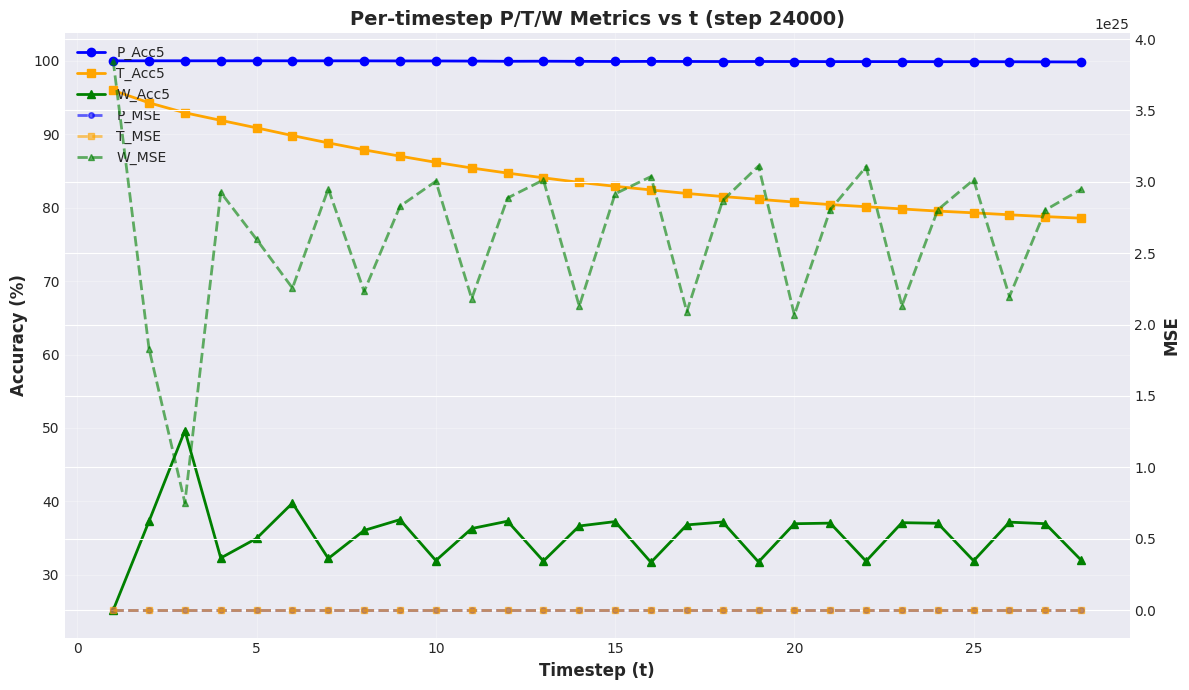

In [37]:
# Plot per-timestep metrics (inline in notebook)
import matplotlib.pyplot as plt

max_steps = MODEL_CONFIG['max_steps']
t = list(range(1, max_steps + 1))

P_Acc5 = per_timestep["P_Acc5"][:max_steps]
T_Acc5 = per_timestep["T_Acc5"][:max_steps]
W_Acc5 = per_timestep["W_Acc5"][:max_steps]
P_MSE = per_timestep["P_MSE"][:max_steps]
T_MSE = per_timestep["T_MSE"][:max_steps]
W_MSE = per_timestep["W_MSE"][:max_steps]

fig, ax1 = plt.subplots(figsize=(12, 7))

# Left y-axis for Acc5
ax1.plot(t, P_Acc5, marker='o', label='P_Acc5', color='blue', linewidth=2, markersize=6)
ax1.plot(t, T_Acc5, marker='s', label='T_Acc5', color='orange', linewidth=2, markersize=6)
ax1.plot(t, W_Acc5, marker='^', label='W_Acc5', color='green', linewidth=2, markersize=6)
ax1.set_xlabel('Timestep (t)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.3)

# Right y-axis for MSE
ax2 = ax1.twinx()
ax2.plot(t, P_MSE, linestyle='--', marker='o', label='P_MSE', color='blue', alpha=0.6, linewidth=2, markersize=4)
ax2.plot(t, T_MSE, linestyle='--', marker='s', label='T_MSE', color='orange', alpha=0.6, linewidth=2, markersize=4)
ax2.plot(t, W_MSE, linestyle='--', marker='^', label='W_MSE', color='green', alpha=0.6, linewidth=2, markersize=4)
ax2.set_ylabel('MSE', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

plt.title(f'Per-timestep P/T/W Metrics vs t (step {step})', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save to report directory
fig_path = REPORT_DIR / f'rollout_metrics_step{step}.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"💾 Saved figure to: {fig_path}")

plt.show()

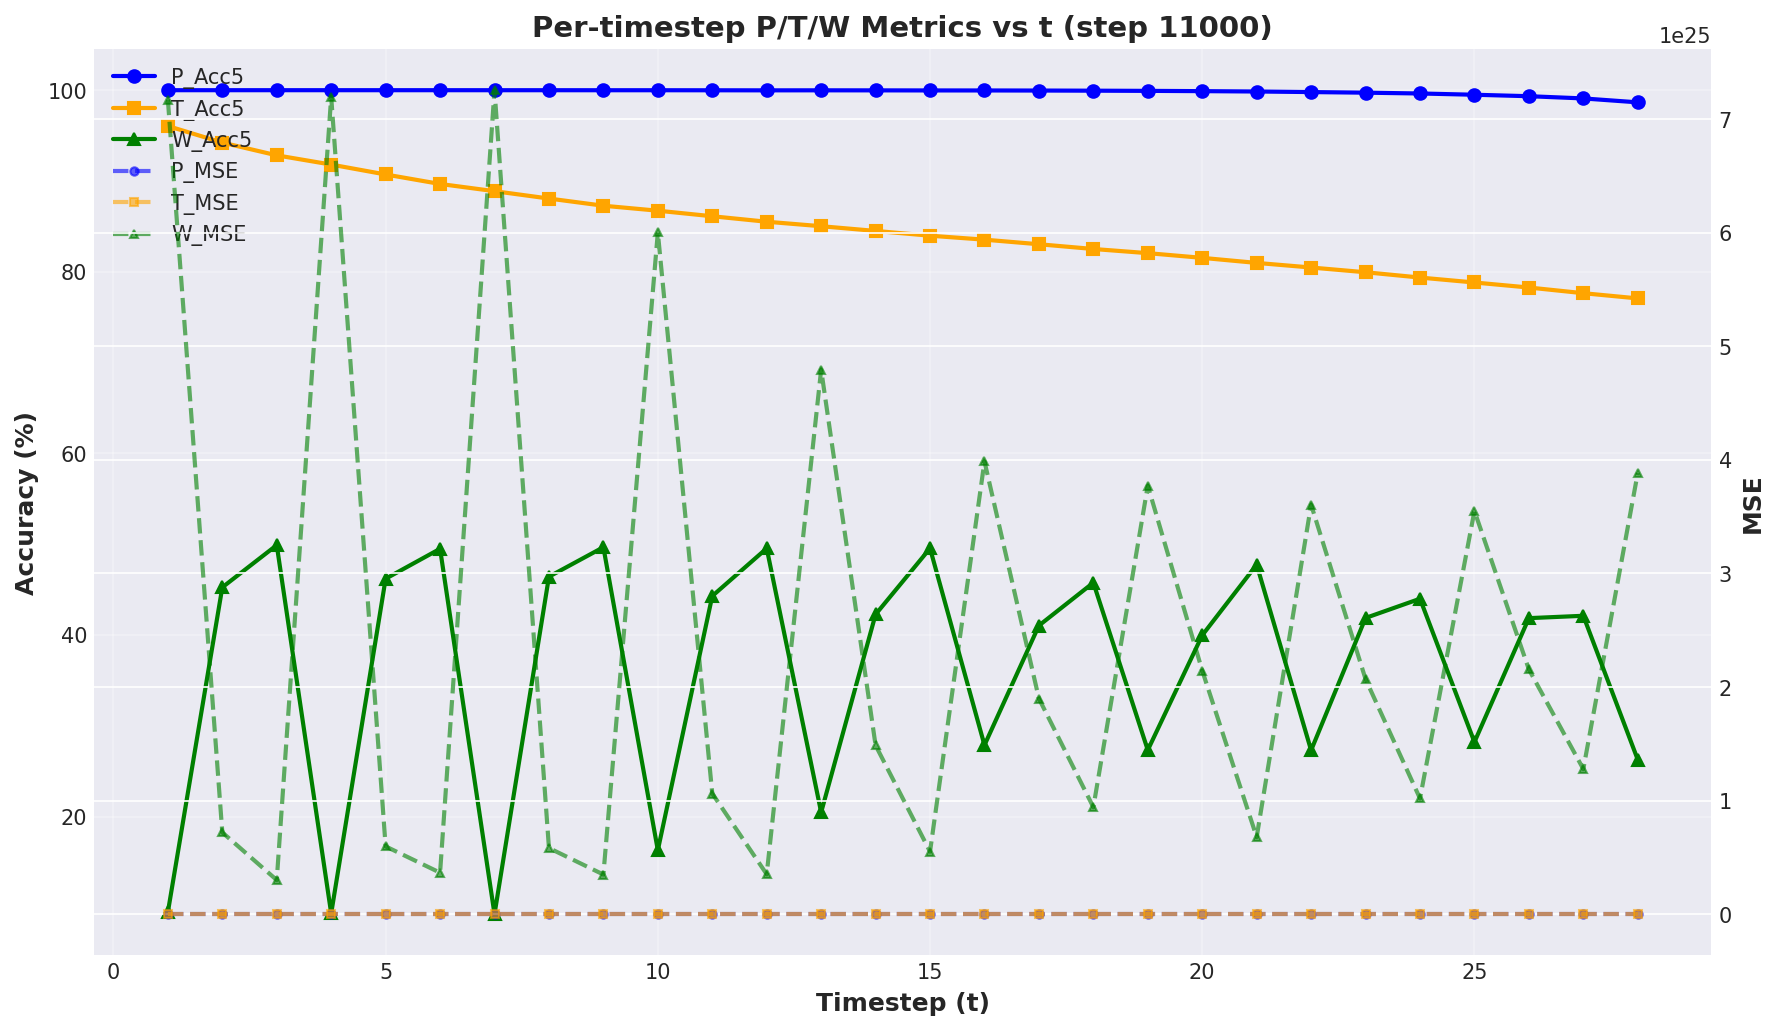


✅ Evaluation complete using scripts/evaluate.py methodology!


In [17]:
# Display the saved figure
from IPython.display import Image as IPImage, display
display(IPImage(filename=str(fig_path)))
print(f"\n✅ Evaluation complete using scripts/evaluate.py methodology!")

In [41]:
# Standalone evaluation for LinearBaseline model (step 600)
import sys
import json
import torch

sys.path.insert(0, '/workspace/omv_v2.5')

from scripts.evaluate import load_model_from_checkpoint, evaluate_rollout_per_timestep

# Configuration
CHECKPOINT_PATH = "/workspace/omv_v2.5/checkpoints_linreg_run1/best_step100.pt"
STATS_PATH = "/workspace/omv_v2.5/data/raw_h5_stats_full.json"
RAW_H5_DIR = "/workspace/all_oak_data/h5s_v2.5_data"
DEVICE = "cuda:0"
MAX_STEPS = 29

# Load stats
with open(STATS_PATH, 'r') as f:
  stats = json.load(f)

# Load model
device = torch.device(DEVICE)
model, step = load_model_from_checkpoint(CHECKPOINT_PATH, stats, device)

# Get test files (first 5)
test_files = [f"v2.5_{i:04d}.h5" for i in range(1, 6)]

print(f"\nRunning {MAX_STEPS}-step rollout evaluation on {len(test_files)} test files...")
print("="*80)

# Run evaluation
per_timestep, summary = evaluate_rollout_per_timestep(
  model=model,
  raw_h5_dir=RAW_H5_DIR,
  stats=stats,
  device=device,
  test_files=test_files,
  max_steps=MAX_STEPS,
)

# Print summary
print(f"\n{'='*80}")
print(f"ROLLOUT EVALUATION RESULTS (step {step})")
print(f"{'='*80}")
print(f"  Files evaluated: {summary['files_evaluated']}")
print(f"\n  [ROLLOUT] MSE - P:{summary['mse_p']:.6e} T:{summary['mse_t']:.6e} WEPT:{summary['mse_w']:.6e}")
print(f"  [ROLLOUT] ACC5 - P:{summary['acc5_p']:.4f} T:{summary['acc5_t']:.4f} WEPT:{summary['acc5_w']:.4f}")

# Print per-timestep table
print(f"\n{'='*80}")
print("PER-TIMESTEP METRICS")
print(f"{'='*80}")
print(f"{'t':>3}  {'P_Acc5':>8}  {'P_MSE':>12}  {'T_Acc5':>8}  {'T_MSE':>12}  {'W_Acc5':>8}  {'W_MSE':>12}")
print("-" * 80)
for i in range(min(MAX_STEPS, len(per_timestep["P_MSE"]))):
  print(f"{i+1:3d}  {per_timestep['P_Acc5'][i]:7.2f}%  {per_timestep['P_MSE'][i]:12.6f}"
        f"{per_timestep['T_Acc5'][i]:7.2f}%  {per_timestep['T_MSE'][i]:12.6f}  "
        f"{per_timestep['W_Acc5'][i]:7.2f}%  {per_timestep['W_MSE'][i]:12.6e}")
print(f"{'='*80}")

Loading checkpoint from /workspace/omv_v2.5/checkpoints_linreg_run1/step600.pt...
Created LinearBaseline model
Loaded model from step 600
Model parameters: 120

Running 29-step rollout evaluation on 5 test files...

ROLLOUT EVALUATION RESULTS (step 600)
  Files evaluated: 5

  [ROLLOUT] MSE - P:1.262176e+03 T:3.981952e+03 WEPT:4.402299e+25
  [ROLLOUT] ACC5 - P:0.0459 T:0.0000 WEPT:0.2414

PER-TIMESTEP METRICS
  t    P_Acc5         P_MSE    T_Acc5         T_MSE    W_Acc5         W_MSE
--------------------------------------------------------------------------------
  1   100.00%     33.487932   0.00%     61.493082     0.00%  8.914095e+25
  2    25.16%    117.001427   0.00%    228.172726     0.00%  8.923836e+25
  3     1.25%    230.753177   0.00%    476.280951    50.00%  7.150187e+23
  4     0.57%    360.605554   0.00%    785.075525    50.00%  6.971747e+23
  5     0.24%    496.947974   0.00%   1137.807983     0.00%  8.968763e+25
  6     0.16%    633.286859   0.00%   1520.728345     0.00% 